In [26]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [27]:
%pip install pydlm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [28]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [29]:
%pip install openpyxl


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
#import data
df = pd.read_csv('../Datasets/INTC Historical Data.csv')

#print data 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,36.60,36.61,36.93,36.27,20.20M,0.91%
1,1/4/2017,36.41,36.71,36.77,36.34,15.92M,-0.52%
2,1/5/2017,36.35,36.45,36.72,36.30,13.99M,-0.16%
3,1/6/2017,36.48,36.46,36.68,36.19,15.11M,0.36%
4,1/9/2017,36.61,36.48,36.88,36.48,19.46M,0.36%


In [32]:
#Bỏ dòng bị trống dự liệu
df = df.dropna()
#Chuyển đổi dữ liệu cột Vol. sang số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1000000


In [33]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,36.60,36.61,36.93,36.27,20200000.0,0.91%
1,1/4/2017,36.41,36.71,36.77,36.34,15920000.0,-0.52%
2,1/5/2017,36.35,36.45,36.72,36.30,13990000.0,-0.16%
3,1/6/2017,36.48,36.46,36.68,36.19,15110000.0,0.36%
4,1/9/2017,36.61,36.48,36.88,36.48,19460000.0,0.36%
...,...,...,...,...,...,...,...
1619,6/9/2023,31.34,31.93,31.99,30.68,40230000.0,-1.51%
1620,6/12/2023,33.07,31.40,33.30,31.36,59670000.0,5.52%
1621,6/13/2023,33.91,33.77,33.95,33.07,51820000.0,2.54%
1622,6/14/2023,35.58,33.87,35.60,33.80,74050000.0,4.92%


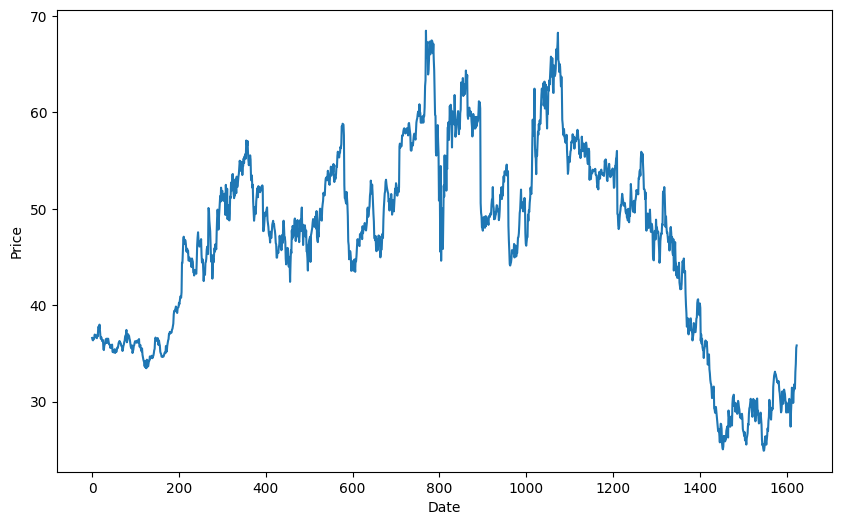

In [34]:
#Đảo ngược dữ liệu cho mô hình
# df = df[::-1]

figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [35]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [36]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [37]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
my_dlm = my_dlm + trend(degree=1, name='trend', w=1.0)

# Thêm seasonality component với chu kỳ 52 tuần
my_dlm = my_dlm + seasonality(period=52, name='season', w=1.0)

In [38]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...


Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [39]:
# Predict on validation set
my_dlm.predictN(N=30)


([57.96590567546607,
  57.81972930982935,
  58.21591858453918,
  58.82385069350297,
  58.847652801527985,
  58.732755493483005,
  58.57991955153072,
  59.013065779159255,
  58.758756070138055,
  58.79602016406876,
  58.632633866256526,
  57.668595047259664,
  57.27714881138893,
  57.75249472415427,
  58.11522829917624,
  57.894997020969456,
  57.249000384874,
  57.99553465993236,
  57.49421487577109,
  57.703500255484954,
  57.82480269515422,
  58.024576996122306,
  58.140994639584534,
  58.60721574912332,
  58.992392430903024,
  59.088992211935455,
  59.12156445453712,
  58.51267686507276,
  59.51030087670148,
  58.899064548393355],
 [26.998396484670366,
  26.891612331084595,
  26.78581996085645,
  26.68100945315697,
  26.57717096611804,
  26.474294737100024,
  26.372371082932297,
  26.271390400127032,
  26.171284078487112,
  26.072159559383756,
  25.97395041194872,
  25.876646972212136,
  25.780239913867636,
  25.68472004465601,
  25.590078278371617,
  25.4963056247644,
  25.40339318

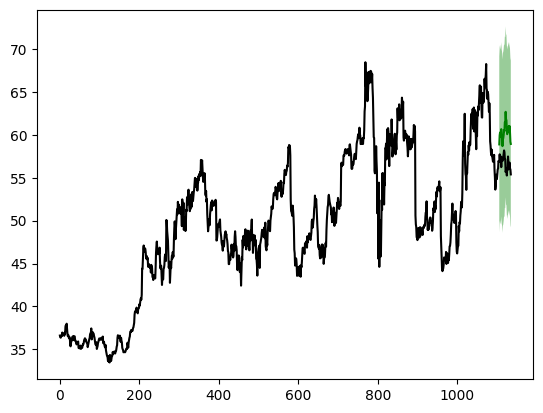

In [40]:
#Dự đoán trên tập train
my_dlm.plotPredictN(N=30, date=my_dlm.n-30)


In [41]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size)

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size)
# Predict on train data
train_preds, train_vars = my_dlm.predictN(N=train_size)

In [42]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [43]:
%pip install scikit-learn


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Testing RMSE: 18.105579292228303
Testing MSE: 327.81200150716637
Testing MAE: 15.179234879988275
Validation RMSE: 30.455834607304823
Validation MSE: 927.5578616275062
Validation MAE: 30.386696152209847


In [45]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [46]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[57.96590567546607, 57.81972930982935, 58.21591858453918, 58.82385069350297, 58.847652801527985, 58.732755493483005, 58.57991955153072, 59.013065779159255, 58.758756070138055, 58.79602016406876, 58.632633866256526, 57.668595047259664, 57.27714881138893, 57.75249472415427, 58.11522829917624, 57.894997020969456, 57.249000384874, 57.99553465993236, 57.49421487577109, 57.703500255484954, 57.82480269515422, 58.024576996122306, 58.140994639584534, 58.60721574912332, 58.992392430903024, 59.088992211935455, 59.12156445453712, 58.51267686507276, 59.51030087670148, 58.899064548393355]


In [47]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [48]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


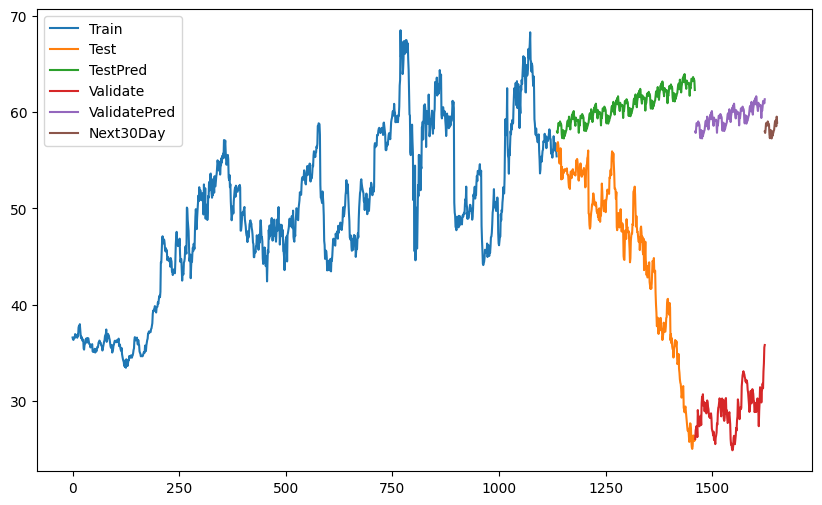

In [49]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')

plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'TestPred', 'Validate', 'ValidatePred', 'Next30Day'])
plt.show()